In [2]:
# Load libraries
# !pip install -r /work/NLP_IMDb_Exam/requirements.txt
import numpy as np
import pandas as pd
import torch
import datasets
import evaluate
import seaborn as sns
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForTokenClassification, AutoModel
from transformers import TrainingArguments, Trainer
from transformers import DataCollatorForTokenClassification
from sentence_transformers import SentenceTransformer

Defaulting to user installation because normal site-packages is not writeable


2024-12-21 14:46:48.680690: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734788809.191233    5879 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734788809.634504    5879 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-21 14:46:52.777665: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Load dataframe into environment
IMDb_dataframe = pd.read_csv('/work/NLP_IMDb_Exam/Data/review_dataframe.csv')


# Check that the merge worked correctly, space oddesey have NA average_rating if merge went wrong
IMDb_dataframe[IMDb_dataframe['movie_title'] == "2001_ A Space Odyssey"]

,movie_title,year,rating,title,review,average_rating
9064,2001_ A Space Odyssey,1968,10,Legendary\n,"A stand-alone monument in cinema history, Stan...",8.3
9065,2001_ A Space Odyssey,1968,10,Unmatched accomplishment\n,Sometimes reading the user comments on IMDB fi...,8.3
9066,2001_ A Space Odyssey,1968,10,"My god, it's full of stars\n",For all those bewildered by the length and pac...,8.3
9067,2001_ A Space Odyssey,1968,7,Ahead of its time but...\n,I felt the need to review this movie after rea...,8.3
9068,2001_ A Space Odyssey,1968,10,A film of monolithic proportions.\n,A review I have put off for far too long....<b...,8.3
...,...,...,...,...,...,...
11162,2001_ A Space Odyssey,1968,10,one of the best movies - ever\n,i saw the movie for the first time last tuesda...,8.3
11163,2001_ A Space Odyssey,1968,Null,quite beautiful for it's time\n,In 1968 I would have been enthralled by the vi...,8.3
11164,2001_ A Space Odyssey,1968,Null,Dynamic!\n,I truly appreciate this film for its lack of d...,8.3
11165,2001_ A Space Odyssey,1968,8,A visually stunning film.\n,Kubrick was one the greatest directors the 20t...,8.3


In [17]:
print(f"Total amount of 'Null'-ratings: {sum(IMDb_dataframe['rating']=="Null")}") # Count nulls
IMDb_dataframe = IMDb_dataframe[IMDb_dataframe['rating'] != "Null"] # Remove nulls
print(f"Total amount of 'Null'-ratings after cleaning: {sum(IMDb_dataframe['rating']=="Null")}") # Count nulls
IMDb_dataframe[IMDb_dataframe['movie_title'] == "2001_ A Space Odyssey"]

Total amount of 'Null'-ratings: 0
Total amount of 'Null'-ratings after cleaning: 0


,movie_title,year,rating,title,review,average_rating
9064,2001_ A Space Odyssey,1968,10,Legendary\n,"A stand-alone monument in cinema history, Stan...",8.3
9065,2001_ A Space Odyssey,1968,10,Unmatched accomplishment\n,Sometimes reading the user comments on IMDB fi...,8.3
9066,2001_ A Space Odyssey,1968,10,"My god, it's full of stars\n",For all those bewildered by the length and pac...,8.3
9067,2001_ A Space Odyssey,1968,7,Ahead of its time but...\n,I felt the need to review this movie after rea...,8.3
9068,2001_ A Space Odyssey,1968,10,A film of monolithic proportions.\n,A review I have put off for far too long....<b...,8.3
...,...,...,...,...,...,...
11159,2001_ A Space Odyssey,1968,8,Turn on your thinking caps\n,"Yes, the film is slow. Yes, there is hardly a...",8.3
11160,2001_ A Space Odyssey,1968,7,Don't take reticence for profundity\n,"It seems misguided to talk about ""ideas"" in Ku...",8.3
11161,2001_ A Space Odyssey,1968,8,Great but Overrated (some bit of spoiling)\n,"I admit, I love this movie. The images that y...",8.3
11162,2001_ A Space Odyssey,1968,10,one of the best movies - ever\n,i saw the movie for the first time last tuesda...,8.3


In [21]:
# Find a way to plot distributions of average_rating and infered rating. Also plot difference.
Movie_name = "Zulu"
IMDb_dataframe["rating"] = pd.to_numeric(IMDb_dataframe["rating"], errors="coerce")
Movie_rating = IMDb_dataframe[IMDb_dataframe['movie_title'] == Movie_name]["rating"]
Movie_rating_online = IMDb_dataframe[IMDb_dataframe['movie_title'] == Movie_name]["average_rating"]
mean_rating = Movie_rating.mean()
print(f"mean rating from reviews {mean_rating}, vs average imdb rating {float(Movie_rating_online.iloc[1])}")

mean rating from reviews 8.555, vs average imdb rating 7.7


In [25]:
def infer_rating(samples):
    # Filter NA's and ensure relevant columns are present
    imdb_filtered = IMDb_dataframe[['movie_title', 'rating', 'average_rating']].dropna()

    # Sample and compute inferred ratings using groupby
    sampled_ratings = (
        imdb_filtered
        .groupby('movie_title')
        .apply(lambda x: x['rating'].sample(n=min(len(x), samples)).mean())
    )

    # Convert to a DataFrame and reset index
    sampled_ratings_df = sampled_ratings.reset_index(name='infered')

    # Merge with original DataFrame to get IMDb average ratings
    merged = pd.merge(
        sampled_ratings_df,
        imdb_filtered[['movie_title', 'average_rating']].drop_duplicates(),
        on='movie_title'
    )

    # Compute the absolute difference
    merged['abs_diff'] = (merged['infered'] - merged['average_rating']).abs()

    #Compute mean squared error
    merged['squared_error'] =(merged['infered'] - merged['average_rating'])**2


    # Rename columns as required
    merged.rename(columns={'average_rating': 'IMDb'}, inplace=True)

    return merged[['infered', 'IMDb', 'abs_diff', 'squared_error']]

/tmp/ipykernel_5879/2245567663.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x['rating'].sample(n=min(len(x), samples)).mean())


The correlation between 'mean of 1 sample(s)' and 'Average online IMDb rating' is 0.26676549487575263
Mean Square Error for 1 samples: 7.660638111888113


/tmp/ipykernel_5879/2245567663.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x['rating'].sample(n=min(len(x), samples)).mean())


The correlation between 'mean of 5 sample(s)' and 'Average online IMDb rating' is 0.5043259943287131
Mean Square Error for 5 samples: 1.7388898601398601


/tmp/ipykernel_5879/2245567663.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x['rating'].sample(n=min(len(x), samples)).mean())


The correlation between 'mean of 20 sample(s)' and 'Average online IMDb rating' is 0.6645897215554495
Mean Square Error for 20 samples: 0.7431621503496504


/tmp/ipykernel_5879/2245567663.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x['rating'].sample(n=min(len(x), samples)).mean())


The correlation between 'mean of 50 sample(s)' and 'Average online IMDb rating' is 0.7253549246145411
Mean Square Error for 50 samples: 0.5556555944055944
The correlation between 'mean of 200 sample(s)' and 'Average online IMDb rating' is 0.7494151620173211
Mean Square Error for 200 samples: 0.45303179056786125


/tmp/ipykernel_5879/2245567663.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x['rating'].sample(n=min(len(x), samples)).mean())


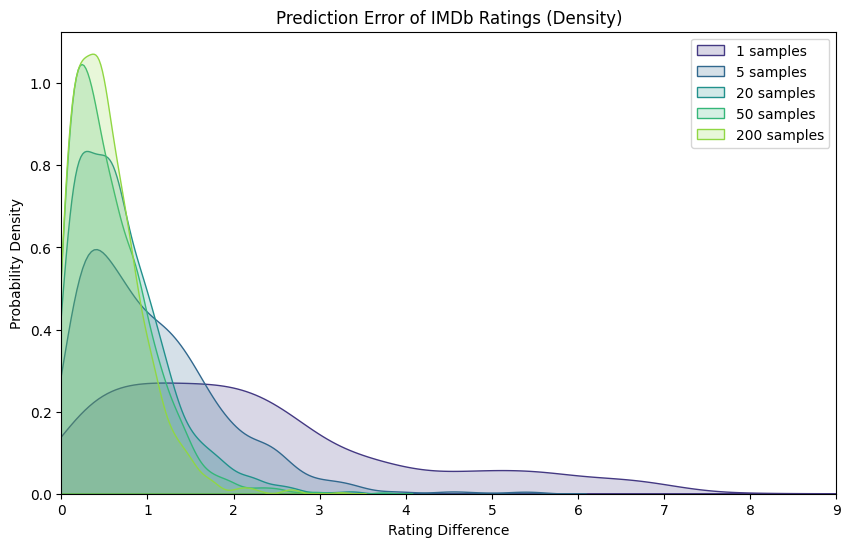

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

samples = [1, 5, 20, 50, 200]

# Set up the figure and axes
plt.figure(figsize=(10, 6))

# Loop through each sample size and plot the KDE curve for each sample size
for sample in samples:
    ratings_df = infer_rating(sample)
    
    # Plot KDE curve for each sample size (normalized to show probability density)
    sns.kdeplot(ratings_df['abs_diff'], color=sns.color_palette("viridis", len(samples))[samples.index(sample)],
                label=f'{sample} samples', alpha=0.2, fill=True)

    # Print correlation and MSE for the sample
    print(f"The correlation between 'mean of {sample} sample(s)' and 'Average online IMDb rating' is {ratings_df.corr().loc['infered', 'IMDb']}")
    print(f"Mean Square Error for {sample} samples: {ratings_df['squared_error'].mean()}")

# Add title and labels
plt.title('Prediction Error of IMDb Ratings (Density)')
plt.xlabel('Rating Difference')
plt.ylabel('Probability Density')

# Limit x-axis to [0, 9]
plt.xlim(0, 9)

# Display the legend
plt.legend()

# Show the plot
plt.show()


In [40]:
# List of sample sizes
samples = [1, 5, 10, 20, 30, 50, 100, 150, 200]

# Create an empty list to store the results
results = []

# Loop through each sample size
for sample in samples:
    ratings_df = infer_rating(sample)
    
    # Extract the correlation and mean squared error
    correlation = ratings_df.corr().loc['infered', 'IMDb']
    mse = ratings_df['squared_error'].mean()
    
    # Append the results as a tuple (sample, correlation, mse)
    results.append((sample, correlation, mse))

# Create a DataFrame from the results
results_df = pd.DataFrame(results, columns=['Sample Size', 'Correlation with IMDb', 'Mean Squared Error'])

# Display the DataFrame
results_df

/tmp/ipykernel_5879/2245567663.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x['rating'].sample(n=min(len(x), samples)).mean())
/tmp/ipykernel_5879/2245567663.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x['rating'].sample(n=min(len(x), samples)).mean())
/tmp/ipykernel_5879/2245567663.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping col

,Sample Size,Correlation with IMDb,Mean Squared Error
0,1,0.280228,7.044729
1,5,0.470002,1.824869
2,10,0.585671,1.010052
3,20,0.672078,0.707664
4,30,0.698907,0.633197
5,50,0.711118,0.586714
6,100,0.731592,0.509052
7,150,0.742909,0.481578
8,200,0.757530,0.449283
